<a href="https://colab.research.google.com/github/Tresor-Koffi/ANPR/blob/main/mage%20Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Captioning**

**Author**: *TRESOR*


**Date created**: *2021/11/08*

**Description**: *Implementation of image captioning model using a CNN and a Transformer.*

##**Environmental set up** 

In [ ]:
!pip install transformers datasets
!pip install -qq fastai==2.5.2
!pip install -q transformers
!pip install -q unpackai==0.1.8.10
!pip install -q torch
!pip install git+https://github.com/huggingface/transformers.git


     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 290 kB 44.2 MB/s 
     |████████████████████████████████| 59 kB 7.1 MB/s 
     |████████████████████████████████| 3.3 MB 33.1 MB/s 
     |████████████████████████████████| 596 kB 35.4 MB/s 
     |████████████████████████████████| 895 kB 38.9 MB/s 
     |████████████████████████████████| 1.1 MB 32.9 MB/s 
     |████████████████████████████████| 243 kB 45.5 MB/s 
     |████████████████████████████████| 132 kB 45.8 MB/s 
     |████████████████████████████████| 160 kB 49.0 MB/s 
     |████████████████████████████████| 271 kB 45.2 MB/s 
     |████████████████████████████████| 192 kB 48.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 186 kB 5.2 MB/s 
     |████████████████████████████████| 831.4 MB 1.4 kB/s 
     |████████████████████████████████| 56

##required Librairies

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
import os
#import torch

In [ ]:
from fastai.vision.all import *
from fastai.text.all import *
from PIL import Image
from unpackai.utils import *
from unpackai.nlp import *

In [ ]:
from transformers import (
    AutoModelWithLMHead,
    AutoTokenizer,
    AutoModel,
    ViTFeatureExtractor,
    PreTrainedTokenizer,
    EncoderDecoderModel
    )

##***Download coco dataset***

In [ ]:
!pip install CocoDataset


In [ ]:
%%time
download_and_unpack("http://images.cocodataset.org/zips/val2014.zip", ".")

CPU times: user 43.6 s, sys: 36.6 s, total: 1min 20s
Wall time: 6min 7s


Path('.')

In [ ]:
# Download caption annotation files
%%time
download_and_unpack("http://images.cocodataset.org/annotations/annotations_trainval2014.zip", ".")

CPU times: user 6.64 s, sys: 2.75 s, total: 9.39 s
Wall time: 55.6 s


Path('.')

##**Preparing dataset**

In [ ]:
ls("annotations")[["Name", "Path", "Last_Modif", "Friendly_Size"]]

,Name,Path,Last_Modif,Friendly_Size
2,captions_train2014.json,annotations/captions_train2014.json,2021-11-17 12:25:51.271539,63.69 MB
3,captions_val2014.json,annotations/captions_val2014.json,2021-11-17 12:25:52.782538,30.92 MB
4,instances_train2014.json,annotations/instances_train2014.json,2021-11-17 12:25:35.805547,317.15 MB
0,instances_val2014.json,annotations/instances_val2014.json,2021-11-17 12:25:41.786544,153.24 MB
5,person_keypoints_train2014.json,annotations/person_keypoints_train2014.json,2021-11-17 12:25:46.366542,162.82 MB
1,person_keypoints_val2014.json,annotations/person_keypoints_val2014.json,2021-11-17 12:25:50.182540,77.86 MB


In [ ]:
ls("val2014")[["Name", "Path", "Last_Modif", "Friendly_Size"]]

,Name,Path,Last_Modif,Friendly_Size
21540,COCO_val2014_000000000042.jpg,val2014/COCO_val2014_000000000042.jpg,2021-11-17 12:23:45.133601,208.31 KB
17921,COCO_val2014_000000000073.jpg,val2014/COCO_val2014_000000000073.jpg,2021-11-17 12:22:50.039633,374.66 KB
3504,COCO_val2014_000000000074.jpg,val2014/COCO_val2014_000000000074.jpg,2021-11-17 12:24:17.679585,172.02 KB
222,COCO_val2014_000000000133.jpg,val2014/COCO_val2014_000000000133.jpg,2021-11-17 12:23:17.669614,159.77 KB
15127,COCO_val2014_000000000136.jpg,val2014/COCO_val2014_000000000136.jpg,2021-11-17 12:23:08.643619,102.62 KB
...,...,...,...,...
15551,COCO_val2014_000000581886.jpg,val2014/COCO_val2014_000000581886.jpg,2021-11-17 12:23:08.144619,92.16 KB
28710,COCO_val2014_000000581887.jpg,val2014/COCO_val2014_000000581887.jpg,2021-11-17 12:22:08.994660,105.04 KB
17411,COCO_val2014_000000581899.jpg,val2014/COCO_val2014_000000581899.jpg,2021-11-17 12:22:12.282659,212.90 KB
31422,COCO_val2014_000000581913.jpg,val2014/COCO_val2014_000000581913.jpg,2021-11-17 12:24:49.822569,135.18 KB


##**Data Analysis**

In [ ]:
path_val = Path("./val2014")
anno = Path("annotations/captions_val2014.json").read_json()

In [ ]:
len(anno['annotations'])

202654

In [ ]:
image_df = pd.DataFrame(anno['images'])
anno_df = pd.DataFrame(anno['annotations'])

In [ ]:
image_df.head()

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,3,COCO_val2014_000000391895.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg,391895
1,4,COCO_val2014_000000522418.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000522418.jpg,480,640,2013-11-14 11:38:44,http://farm1.staticflickr.com/1/127244861_ab0c0381e7_z.jpg,522418
2,3,COCO_val2014_000000184613.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000184613.jpg,336,500,2013-11-14 12:36:29,http://farm3.staticflickr.com/2169/2118578392_1193aa04a0_z.jpg,184613
3,3,COCO_val2014_000000318219.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000318219.jpg,640,556,2013-11-14 13:02:53,http://farm5.staticflickr.com/4125/5094763076_813ea2751b_z.jpg,318219
4,3,COCO_val2014_000000554625.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000554625.jpg,640,426,2013-11-14 16:03:19,http://farm5.staticflickr.com/4086/5094162993_8f59d8a473_z.jpg,554625


In [ ]:
anno_df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wheel.
1,179765,38,A black Honda motorcycle parked in front of a garage.
2,322141,49,A room with blue walls and a white sink and door.
3,16977,89,A car that seems to be parked illegally behind a legally parked car
4,106140,98,A large passenger airplane flying through the air.


In [ ]:
file_name_2_id = dict(image_df[["file_name","id",]].values)
id_2_caption = dict(anno_df[["image_id","caption"]].values)

In [ ]:
pd.merge(
     left= anno_df,
    right= image_df,
    how="inner",
    left_on = "image_id",
    right_on = "id",
)

,image_id,id_x,caption,license,file_name,coco_url,height,width,date_captured,flickr_url,id_y
0,203564,37,A bicycle replica with a clock as the front wheel.,4,COCO_val2014_000000203564.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000203564.jpg,400,400,2013-11-15 03:12:47,http://farm8.staticflickr.com/7366/9643253026_86d6e38def_z.jpg,203564
1,203564,181,The bike has a clock as a tire.,4,COCO_val2014_000000203564.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000203564.jpg,400,400,2013-11-15 03:12:47,http://farm8.staticflickr.com/7366/9643253026_86d6e38def_z.jpg,203564
2,203564,478,A black metal bicycle with a clock inside the front wheel.,4,COCO_val2014_000000203564.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000203564.jpg,400,400,2013-11-15 03:12:47,http://farm8.staticflickr.com/7366/9643253026_86d6e38def_z.jpg,203564
3,203564,6637,A bicycle figurine in which the front wheel is replaced with a clock\n,4,COCO_val2014_000000203564.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000203564.jpg,400,400,2013-11-15 03:12:47,http://farm8.staticflickr.com/7366/9643253026_86d6e38def_z.jpg,203564
4,203564,6802,A clock with the appearance of the wheel of a bicycle,4,COCO_val2014_000000203564.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000203564.jpg,400,400,2013-11-15 03:12:47,http://farm8.staticflickr.com/7366/9643253026_86d6e38def_z.jpg,203564
...,...,...,...,...,...,...,...,...,...,...,...
202649,347648,815172,A hand carved vase sitting on a blue cloth.,1,COCO_val2014_000000347648.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000347648.jpg,428,640,2013-11-24 18:30:11,http://farm8.staticflickr.com/7010/6445027757_785f40ecd8_z.jpg,347648
202650,347648,817186,A vase sitting on display and tilted a bit to the right.,1,COCO_val2014_000000347648.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000347648.jpg,428,640,2013-11-24 18:30:11,http://farm8.staticflickr.com/7010/6445027757_785f40ecd8_z.jpg,347648
202651,347648,817429,a close up of a vase with decorations,1,COCO_val2014_000000347648.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000347648.jpg,428,640,2013-11-24 18:30:11,http://farm8.staticflickr.com/7010/6445027757_785f40ecd8_z.jpg,347648
202652,347648,818227,A vase and lids are sitting on a table.,1,COCO_val2014_000000347648.jpg,http://images.cocodataset.org/val2014/COCO_val2014_000000347648.jpg,428,640,2013-11-24 18:30:11,http://farm8.staticflickr.com/7010/6445027757_785f40ecd8_z.jpg,347648


##**Tokenizer**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
def get_y(path: Path):
    # file name of the iamge path
    file_name = path.name
    # get the caption according to image file name
    idx = file_name_2_id.get(file_name)
    return f": {id_2_caption.get(idx)}"

In [ ]:
INPUT_MEAN = [.5,.5,.5]
INPUT_STD = [.5,.5,.5]

In [ ]:
from unpackai.nlp import HFTextBlock

##**HF Text Block**

In [ ]:
dblock = DataBlock(blocks = (
    ImageBlock,
    HFTextBlock(tokenizer,max_length=32,padding="max_length",truncation=True)),
                   get_items = get_image_files,
                   item_tfms = Resize(224),
                   batch_tfms=[
                               IntToFloatTensor(),
                               Normalize.from_stats(INPUT_MEAN,INPUT_STD),],
                   get_y     = get_y,
                   splitter  = RandomSplitter(),
                   )

In [ ]:
def batch_x_merge_y(batch, b):
    x, y = batch
    return (x, y), y

dblock.dls_kwargs['retain'] = batch_x_merge_y

In [ ]:
dsets = dblock.datasets(path_val)
x, y = dsets.train[0]

text being:	: A cow in the pasture drinking from a lake.


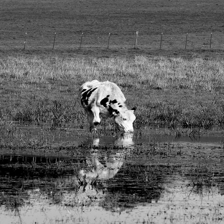

In [ ]:
print(f"text being:\t{y}")
x.resize((224,224))

In [ ]:
dls = dblock.dataloaders(path_val, bs=16)

In [ ]:
batch = dls.one_batch()

In [ ]:
(batch_img, batch_txt), batch_txt2 = batch

In [ ]:
batch_img.shape, batch_txt.shape, batch_txt2.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 32]), torch.Size([16, 32]))

##**Building the model**

In [ ]:
encoder = AutoModel.from_pretrained('google/vit-base-patch16-224-in21k')
decoder = AutoModelWithLMHead.from_pretrained("gpt2", add_cross_attention=True)
decoder.tokenizer = tokenizer

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:712: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.5.crossattention.masked_bias', 'h.6.crossattention.bias', 'h.5.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.weight', 'h.6.ln_cross_attn.weight', 'h.7.ln_cross_attn.weight', 'h.2.crossattention.masked_bias', 'h.5.crossattention.c_attn.weight', 'h.2.crossattention.c_proj.weight', 'h.8.crossattention.c_proj.weight', 'h.7.crossattention.c_proj.weight', 'h.4.crossattention.masked_bias', 'h.9.crossattention.c_attn.weight', 'h.6.crossattention.masked_bias', 'h.11.crossattention.masked_bias', 'h.4.ln_cross_attn.weight', 'h.11.crossattention.bias', 'h.5.crossattention.c_proj.bias', 'h.11.crossattention.q_attn.weight', 'h.1.crossattention.bias', 'h.9.crossattention.bias', 'h.6.crossattention.c_attn.weight', 'h.10.crossattention.c_attn.weight', 'h.7.crossattention.c_proj.bias', 'h.3.crossattention.q_attn.weight', 'h.11.crossattention.c_attn.weight', 'h.10.crossattenti

In [ ]:
class Caption(nn.Module):
    """
    The caption model is created by
        combining decoder and encoder
    """
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        """
        
        - encoder: The encoder model that can extract image features
        - decoder: The decoder model that can generate text sequence
            - you have to set add_cross_attention
                to True when instantiate the model
        """
        super().__init__()
        self.encoder_decoder = EncoderDecoderModel(
            encoder=encoder,
            decoder=decoder,)
        
        # update generate documentation
        self.generate.__func__.__doc__ = f"""
        Generate text with image:
        - batch_img: a batch of image tensor
        - other generate kwargs please see following
        {self.encoder_decoder.decoder.generate.__doc__}"""
        
    def forward(self, inputs):
        x, input_ids = inputs
        # extract image feature with encoder
        # the extracted feature we call them: encoder_outputs
        encoder_outputs = self.encoder_decoder.encoder(x)
        
        # predict text sequence logits
        # with the encoder_outputs
        seq_out = self.encoder_decoder(
            encoder_outputs=encoder_outputs,
            # decoder_inputs is to help decoders learn better, 
            # decoder has mask that allow model to see
            # only the previous text tokens and encoder feature
            decoder_input_ids=input_ids,
            labels=input_ids,
            )
        return seq_out
    
    def generate(self, batch_img, **generate_kwargs):
        with torch.no_grad():
            # extract image features first
            encoder_outputs = self.encoder_decoder.encoder(pixel_values=batch_img)
            return self.encoder_decoder.decoder.tokenizer.batch_decode(
                # encoder_decoder has a 'generate' function we can use
                self.encoder_decoder.generate(
                    encoder_outputs=encoder_outputs,
                    **generate_kwargs), )

In [ ]:
def use_output_loss(output, label):
    return output.loss

In [ ]:
def hf_accuracy(output, label):
    return (output.logits.argmax(-1)==label).float().mean()

In [ ]:
model = Caption(encoder, decoder)

In [ ]:
learn = Learner(dls, model, loss_func=use_output_loss, metrics=[hf_accuracy], )

In [40]:
learn.fit(1)

epoch,train_loss,valid_loss,hf_accuracy,time


/usr/local/lib/python3.7/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:490: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


epoch,train_loss,valid_loss,hf_accuracy,time
0,0.000709,0.001949,0.999641,1:01:32


In [42]:
learn.fit(2)

epoch,train_loss,valid_loss,hf_accuracy,time
0,0.001859,0.000988,0.999772,1:01:21


/usr/local/lib/python3.7/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:490: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


epoch,train_loss,valid_loss,hf_accuracy,time
0,0.001859,0.000988,0.999772,1:01:21
1,0.000603,0.000694,0.999838,1:01:24


In [46]:
encoder = encoder.eval()

In [54]:
model.generate(batch_img[:2,...],
               top_p=.6, do_sample=True, # text generation startegy
               bos_token_id=tokenizer.vocab[':'],)[0].replace("<|endoftext|>","")

'::::::::::::::::::::'

In [55]:
tokenizer.batch_decode(batch_txt)[0].replace("<|endoftext|>","")

': Man in red and white uniform pitching a baseball.'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


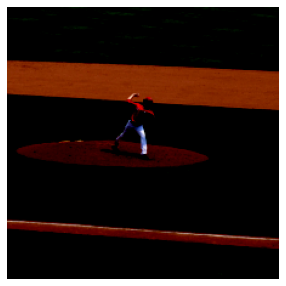

In [53]:
batch_img[0,...].show()